In [2]:
!pip install transformers datasets tiktoken

In [85]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from IPython.display import clear_output
import tiktoken
import math
import requests

In [86]:
data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
data = requests.get(data_url).text

In [88]:
type(data)

str

In [89]:
n = len(data)
train_data = data[:int(n*0.9)]
val_data = data[int(n*0.9):]

enc = tiktoken.get_encoding('gpt2')
train_ids = enc.encode_ordinary(train_data)
val_ids = enc.encode_ordinary(val_data)

In [90]:
train_ids[:10]

[5962, 22307, 25, 198, 8421, 356, 5120, 597, 2252, 11]

In [91]:
data[:100]

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'

In [92]:
enc.decode([5962, 22307, 25, 198, 8421, 356, 5120, 597, 2252, 11])

'First Citizen:\nBefore we proceed any further,'

In [93]:
seq_len = 64
batch_size = 64
vocab_size = enc.n_vocab
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [94]:
# Language task.
def get_batch(split):
  ds = train_ids
  if split == 'val':
    ds = val_ids

  ix = torch.randint(0, len(ds)-seq_len, (batch_size, ))
  x = torch.stack([torch.Tensor(ds[i:i+seq_len]) for i in ix]).type(torch.LongTensor)
  y = torch.stack([torch.Tensor(ds[i+1:i+1+seq_len]) for i in ix]).type(torch.LongTensor)

  return x.to(device), y.to(device)

In [95]:
# Number sequence reversal task.
def get_batch2(split):
  vocab_size = 20
  ds = train_ids
  if split == 'val':
    ds = val_ids

  x = torch.randint(0, vocab_size, size=(batch_size, seq_len))
  y = torch.flip(x, dims=(1,))

  return x.to(device), y.to(device)

In [96]:
x, y = get_batch('train')

In [97]:
class ResiLN(torch.nn.Module):
  def __init__(self, hidden_size):
    super().__init__()

    self.ln = torch.nn.LayerNorm(hidden_size)

  def forward(self, x, x_in):
    return self.ln(x + x_in)

In [98]:
class MultiHeadAttention(torch.nn.Module):
  def __init__(self, hidden_size, n_head, bidirectional=True):
    super().__init__()

    assert hidden_size % n_head == 0

    d = hidden_size // n_head

    self.hidden_size = hidden_size
    self.d = d
    self.n_head = n_head
    self.w_q = torch.nn.Linear(hidden_size, hidden_size)
    self.w_k = torch.nn.Linear(hidden_size, hidden_size)
    self.w_v = torch.nn.Linear(hidden_size, hidden_size)
    self.w_out = torch.nn.Linear(hidden_size, hidden_size)
    self.mask = not bidirectional
    self.rln = ResiLN(hidden_size)

  def forward(self, x):
    B, L, _ = x.shape
    q = self.w_q(x).reshape(B, L, self.d, self.n_head) # B x L x d x h
    k = self.w_k(x).reshape(B, L, self.d, self.n_head)
    v = self.w_v(x).reshape(B, L, self.d, self.n_head)
    m = None
    if self.mask:
      m = self.generate_mask(x)

    out, ws = self.compute_attn(q, k, v, m)
    B, L, _ = x.shape
    out = self.w_out(out.reshape(B, L, -1))
    return self.rln(out, x), ws

  def generate_mask(self, x):
    _, L, _ = x.shape
    return torch.tril(torch.ones(L, L))

  def compute_attn(self, q, k, v, mask=None):
    _, _, d, n_head = q.shape
    q, k, v = q.permute(0, 3, 1, 2), k.permute(0, 3, 1, 2), v.permute(0, 3, 1, 2)
    out = torch.matmul(q, k.transpose(2, 3)) / math.sqrt(d)

    if mask is not None:
      out.masked_fill_((mask == 0).to(device), -float('Inf'))

    out = torch.nn.functional.softmax(out, dim=-1)
    return torch.matmul(out, v).permute(0, 2, 3, 1), out

In [99]:
class FFN(torch.nn.Module):
  def __init__(self, in_dim, hidden_dim):
    super().__init__()

    self.w1 = torch.nn.Linear(in_dim, hidden_dim)
    self.w2 = torch.nn.Linear(hidden_dim, in_dim)
    self.relu = torch.nn.ReLU()
    self.rln = ResiLN(in_dim)

  def forward(self, x):
    out = self.w2(self.relu(self.w1(x)))
    return self.rln(out, x)

In [100]:
class DecoderBlock(torch.nn.Module):
  def __init__(self, hidden_size, hidden_mlp, n_head):
    super().__init__()

    self.attn = MultiHeadAttention(hidden_size, n_head, bidirectional=False)
    self.ffn = FFN(hidden_size, hidden_mlp)

  def forward(self, x):
    a, ws = self.attn(x)
    return self.ffn(a), ws

In [101]:
class Decoder(torch.nn.Module):
  def __init__(self, n_block, hidden_size, hidden_mlp, n_head):
    super().__init__()

    self.blocks = torch.nn.ModuleList([DecoderBlock(hidden_size, hidden_mlp, n_head) for _ in range(n_block)])

  def forward(self, x):
    ws = []
    for block in self.blocks:
      x, w = block(x)
      ws.append(w)

    return x, ws

In [102]:
class Embedding(torch.nn.Module):
  def __init__(self, vocab_size, emb_dim, device, padding_idx=None):
    super().__init__()

    self.emb = torch.nn.Embedding(vocab_size, emb_dim, padding_idx)
    self.device = device

  def forward(self, x):
    out = self.emb(x)
    pos = self.pos_encode(out)
    return out + pos

  def pos_encode(self, x):
    B, L, d = x.shape

    assert d%2 == 0

    v1 = torch.arange(0, L, dtype=torch.float).reshape(-1, 1)
    pos = torch.arange(0, d // 2, dtype=torch.float)
    v2 = torch.pow(torch.ones(d, dtype=torch.float) * 1/10000, pos.repeat_interleave(2) * 2/d)
    v3 = torch.mm(v1, v2.reshape(1, -1))
    v3[:, torch.arange(0, d, 2)] = torch.sin(v3[:, torch.arange(0, d, 2)])
    v3[:, torch.arange(1, d, 2)] = torch.cos(v3[:, torch.arange(1, d, 2)])
    return v3.reshape(1, L, d).to(device)

In [103]:
class LangModel(torch.nn.Module):
  def __init__(self, n_block, hidden_size, hidden_mlp, n_head, vocab_size, device):
    super().__init__()

    self.emb = Embedding(vocab_size, hidden_size, device)
    self.dec = Decoder(n_block, hidden_size, hidden_mlp, n_head)
    self.lin = torch.nn.Linear(hidden_size, vocab_size)
    self.device = device

  def forward(self, x):
    x = self.emb(x)
    #plt.imshow(x.squeeze().detach().numpy())
    out, ws = self.dec(x)
    return self.lin(out), ws

In [104]:
def loss_fn(p, y):
  l = torch.nn.CrossEntropyLoss()
  # Cross entropy loss requires the input to be of form (B, n_class, ...).
  # The input to loss function is of form (B, seq_len, C).
  return l(p.transpose(1, 2), y)

In [105]:
class Trainer:
  def __init__(self, lr, n_epochs, device):
    self.lr = lr
    self.n_epochs = n_epochs
    self.device = device
    self.es = []
    self.t_loss = []
    self.v_loss = []

  def step_epoch(self, mdl, split, opti, criterion, device):
    if split == 'train':
      mdl.train()
    else:
      mdl.eval()

    losses = []
    for _ in range(10):
      x, y = get_batch(split)

      if split == 'train':
        opti.zero_grad()

      p, _ = mdl(x)
      l = criterion(p, y)

      if split == 'train':
        l.backward()
        opti.step()
      losses.append(l.item())

    return np.mean(losses)

  def fit(self, mdl):
    mdl = mdl.to(self.device)
    opti = torch.optim.Adam(mdl.parameters())
    for epoch in tqdm(range(len(self.es)+1, self.n_epochs+len(self.es)+1)):
      self.t_loss.append(self.step_epoch(mdl, 'train', opti, loss_fn, self.device))
      self.v_loss.append(self.step_epoch(mdl, 'val', opti, loss_fn, self.device))
      self.es.append(epoch)

      clear_output()
      plt.plot(self.es, self.t_loss, label='train_loss')
      plt.plot(self.es, self.v_loss, label='val_loss')
      plt.legend(loc="upper right")
      plt.show()

      print('\n')
      print(f'Epoch: {epoch}')
      print(f'Train loss: {self.t_loss[-1]} (this), {np.mean(self.t_loss)} (avg)')
      print(f'Val loss: {self.v_loss[-1]} (this), {np.mean(self.v_loss)} )avg')
      print('\n')

In [106]:
# Constants.
hidden_size = 128
hidden_mlp = 64

n_block = 1
n_head = 4

In [107]:
mdl = LangModel(n_block, hidden_size, hidden_mlp, n_head, vocab_size, device).to(device)

In [108]:
trainer = Trainer(None, None, device)

In [161]:
lr = 5e-6
n_epochs = 1

In [162]:
trainer.lr = lr
trainer.n_epochs = n_epochs

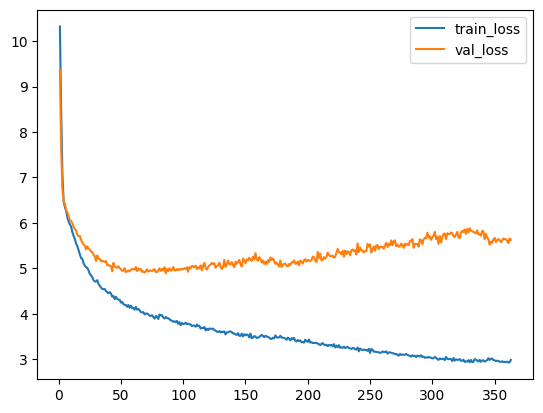

100%|██████████| 1/1 [00:02<00:00,  2.88s/it]



Epoch: 363
Train loss: 2.9855004072189333 (this), 3.6449343437662467 (avg)
Val loss: 5.6269224166870115 (this), 5.350239310514172 )avg




In [163]:
trainer.fit(mdl)

In [25]:
from google.colab import drive
drive.mount('/content/gdrive')
PATH = F"/content/gdrive/My Drive/ML/jacob_hilton/transformer.pth"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [117]:
torch.save(mdl.state_dict(), PATH)

In [ ]:
mdl.load_state_dict(torch.load(PATH, map_location=device))
mdl.to(device)

In [131]:
def predict(mdl, x):
  out, ws = mdl(x.unsqueeze(dim=0))
  sm = torch.nn.Softmax(dim=-1)
  return torch.argmax(sm(out), dim=-1)

In [160]:
cw = seq_len
lm_pred = train_ids[100:100+cw]
for i in range(300):
  out = predict(mdl, torch.Tensor(lm_pred[-cw:]).type(torch.LongTensor).to(device))
  lm_pred.append(out[0][-1])
print('Prompt: ', enc.decode(train_ids[100:100+cw]))
print('End prompt')
print(enc.decode(lm_pred))

Prompt:  'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
End prompt
'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.

DUKE VINCENTIO:
I have you to hear him speak.

CORIOLANUS:
I am not to be so.

LADY GREY:
I mean, sir, sir, sir, sir,
take it not be, nor any man.

ROMEO:
I have been a sleeper; and so, as I
As well as I do, as I said,
As I have heard him to be a sepulchre,
And make conceive in streams of the king,
And in the stocks avouch act of a
it, and I am a gentleman, and not
Play'd in the winter's behalf of the north,
And yet I am a prone and to speak.

LUCIO:
I'll be hanged first to be the queen.

HENRY BOLINGBROKE:
I know not, sir, sir, sir,
how you w